In [1]:
from IPython.display import display

from sympy.interactive import printing
printing.init_printing(use_latex=True)

from __future__ import division
import sympy as sym
from sympy import *

%matplotlib inline
from matplotlib import rc
import matplotlib.pyplot as plt
rc('font',**{'family':'serif','size'   : 12})

In [2]:
from qutip import *

# Several constants

In [3]:
from __future__ import division, print_function, unicode_literals

# Basic constants
pi = 3.1415926
c = 299792458
h = 6.62606957e-34
hbar = h / 2 / pi
k_B = 1.3806488e-23
m_e = 9.10938291e-31
m_p = 1.672621898e-27
mu_0 = 4e-7 * pi
epsilon_0 = 1 / c**2 / mu_0
E = 1.602176565e-19
N_A = 6.02214129e+23


# Mass of Sr-88, Sr-87, Sr-86, Sr-84
M88 = 1.459706905272492E-25  
M87 = 1.4431557366419E-25  
M86 = 1.42655671117996E-25
M84 = 1.3934150821E-25
M = M88

In [4]:
# For running wave the important parameter is the phase 
# Note that cooling can be extremely small for phi = 0 (antinode)
from scipy.optimize import curve_fit

def f(x, a, b, c):
    return a * exp(-2 * pi * b * x) + c 

import timeit
from numpy import linspace, arange, divide, sqrt, exp
from scipy import stats

Nx = 15   # Dimension of x-harmonic oscillator
mx = 10
Ny = 5  
my = 2
Nz = 5   
mz = 2

# Trapping frequencies along those axis
omega_x = 2 * pi * 200  # In units of kHz
omega_y = 2 * pi * 200  # In units of kHz
omega_z = 2 * pi * 33   # In units of kHz

# we assume a common delta for all three beams
delta = -2 * pi * 200   # In units of kHz

# Rabi frequencis for three beams
omega_1 = 2 * pi * 50   # In units of kHz
omega_2 = 2 * pi * 10000   # In units of kHz
omega_3 = 2 * pi * 1000   # In units of kHz
gamma = 2 * pi * 7      # In units of kHz

# Lamb-Dicke parameter along those axis
eta_x = 0.15
eta_y = 0.15
eta_z = 0.38
g = basis(2,0)          # Ground state
e = basis(2,1)          # Excited state
x = fock(Nx, mx)        # x-harmonic oscillator
y = fock(Ny, my)        # y-harmonic oscillator
z = fock(Nz, mz)        # z-harmonic oscillator

# Position in the standing waves
phi_1 = 0.5 * pi
phi_2 = 0.5 * pi
phi_3 = 0.5 * pi

# Recoil energy of the blue
Recoil_461 = (hbar * 2 * pi / (461E-9)) ** 2 / (hbar * 2 * M88 * 1000)
#print(Recoil_461)

# Destruction operators in 3d
a_x = tensor(destroy(Nx), qeye(Ny), qeye(Nz))
a_y = tensor(qeye(Nx), destroy(Ny), qeye(Nz))
a_z = tensor(qeye(Nx), qeye(Ny), destroy(Nz))
eye_xyz = tensor(qeye(Nx), qeye(Ny), qeye(Nz))

$\tilde{H}= H_x + H_{yz}-\hbar \frac{\bar{\delta}}{2} \sigma_z$

$H_x = \hbar \omega_x (a_x^{+}a_x+\frac{1}{2}) + \hbar\Omega_3 ( \sigma_{+}cos(ik_3x + \phi_{3})e^{-i(\delta_3 - \bar{\delta})t} +h.c.)$

$H_{yz} = \hbar \omega_y (a_y^{+}a_y+\frac{1}{2}) + \hbar \omega_z (a_z^{+}a_z+\frac{1}{2}) + \hbar \Omega_1 (\sigma_{+} cos(k_1 (\frac{\sqrt{3}}{2} y -\frac{1}{2} z)+ \phi_{1}))e^{-i(\delta_1 - \bar{\delta}) t} + h.c.) + \hbar \Omega_2 (\sigma_{+}cos(k_2 (\frac{-\sqrt{3}}{2} y -\frac{1}{2} z)+ \phi_{2}))e^{-i(\delta_2 - \bar{\delta}) t} + h.c.)$

In [5]:
# H / hbar, otherwise too small, too many floats
# Now the two Hamiltonians give different result, I trust the second one
He = tensor(eye_xyz, 0.5 * delta * sigmaz())
Hx = tensor(omega_x * (a_x.dag() * a_x + 0.5), qeye(2)) + omega_3 * 0.5 * (tensor((1j * (eta_x * (a_x + a_x.dag()) + phi_3)).expm() + (-1j * (eta_x * (a_x + a_x.dag()) + phi_3)).expm(), sigmax()))
Hyz = tensor(omega_y * (a_y.dag() * a_y + 0.5), qeye(2)) + tensor(omega_z * (a_z.dag() * a_z + 0.5), qeye(2)) + omega_1 * 0.5 * (tensor((1j * (sqrt(3) / 2 * eta_y * (a_y + a_y.dag()) - 1 / 2 * eta_z * (a_z + a_z.dag()) + phi_1)).expm() + (-1j * (sqrt(3) / 2 * eta_y * (a_y + a_y.dag()) - 1 / 2 * eta_z * (a_z + a_z.dag()) + phi_1)).expm(), sigmax())) + omega_2 * 0.5 * (tensor((1j * (-1 * sqrt(3) / 2 * eta_y * (a_y + a_y.dag()) - 1 / 2 * eta_z * (a_z + a_z.dag()) + phi_2)).expm() + (-1j * (-1 * sqrt(3) / 2 * eta_y * (a_y + a_y.dag()) - 1 / 2 * eta_z * (a_z + a_z.dag()) + phi_2)).expm(), sigmax()))

H = Hx + Hyz - He
# Wavefunction in 3d, start from all in ground state
psi0 = tensor(x, y, z, g)

## Sampling isotropic distribution

$p(\theta, \phi)d\theta d\phi = \frac{d \Omega}{4 \pi} = \frac{sin(\theta) d\theta}{2}\frac{d\phi}{2 \pi} = p(\theta) d\theta p(\phi)d\phi $

Define two random variables $u_1, u_2$ from uniform distribution $[0, 1]$, we then have

$\phi = 2 \pi u_1$

$cos(\theta) = 1 - 2 u_2$

Then we get the corresponding $x, y, z$ direction

$\frac{x}{r} = sin(\theta) cos(\phi)$

$\frac{y}{r} = sin(\theta) sin(\phi)$

$\frac{z}{r} = cos(\theta) = 1 - 2 u_2$

[[-0.85881707165785759, -0.21171217903402287, -0.46648814634209984]]
10.0%. Run time:  61.53s. Est. time left: 00:00:09:13
20.0%. Run time:  62.24s. Est. time left: 00:00:04:08
30.0%. Run time: 122.17s. Est. time left: 00:00:04:45
40.0%. Run time: 122.39s. Est. time left: 00:00:03:03
50.0%. Run time: 181.08s. Est. time left: 00:00:03:01
60.0%. Run time: 181.38s. Est. time left: 00:00:02:00
70.0%. Run time: 239.92s. Est. time left: 00:00:01:42
80.0%. Run time: 240.54s. Est. time left: 00:00:01:00
90.0%. Run time: 297.13s. Est. time left: 00:00:00:33
100.0%. Run time: 297.93s. Est. time left: 00:00:00:00
Total run time: 298.01s
298.512971163


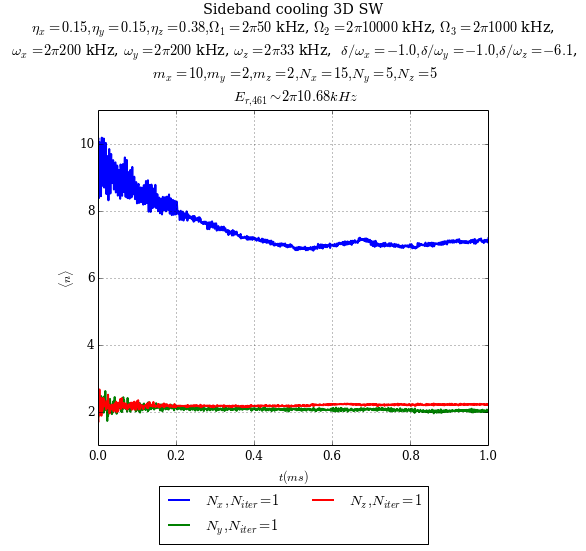

In [6]:
# Now exact solver can't do anything but the Monte Carlo solver is efficient
# Can try the Fortran based Monte Carlo solver
# By default, mcsolve average over 500 trajectories
# Randomly generate u_1 and u_2 from isotropic distribution
from numpy.random import uniform
from numpy import cos, sin, arccos, arcsin
def Isotropic(N_iter):
    u = []
    for i in range(N_iter):
        u1 = uniform(0, 1)
        u2 = uniform(0, 1)
        phi = 2 * pi * u1
        theta = arccos(1 - 2 * u2)
        u.append([sin(theta) * cos(phi), sin(theta) * sin(phi), cos(theta)])
    return u

dt = 1    # Time length
times = linspace(0.0, dt, 1000)
# N_iter = [1, 5, 10, 20]
# N_iter = [1, 5]
N_iter = [1]

import matplotlib.gridspec as gridspec
figure = plt.figure(figsize=(7, 6))
gs = gridspec.GridSpec(1, 1)
gs.update(wspace=0.3,hspace=0.4)
ax1 = plt.subplot(gs[0,0]) 
start = timeit.default_timer()

for N_iter_ in N_iter:
    u = Isotropic(N_iter_)
    print(u) 
    result = mcsolve(H, psi0, times, [sqrt(gamma) / sqrt(N_iter_) * tensor((1j * (u[i][0] * eta_x * (a_x + a_x.dag()) + u[i][1] * eta_y * (a_y + a_y.dag()) + u[i][2] * eta_z * (a_z + a_z.dag()))).expm(), sigmam()) for i in range(N_iter_)], [tensor(a_x.dag() * a_x, qeye(2)), tensor(a_y.dag() * a_y, qeye(2)), tensor(a_z.dag() * a_z, qeye(2))], 10)
    ax1.plot(result.times, result.expect[0], label = '$N_x, N_{iter} = %d$' % (N_iter_), linewidth = 2, linestyle = '-');
    ax1.plot(result.times, result.expect[1], label = '$N_y, N_{iter} = %d$' % (N_iter_), linewidth = 2, linestyle = '-');
    ax1.plot(result.times, result.expect[2], label = '$N_z, N_{iter} = %d$' % (N_iter_), linewidth = 2, linestyle = '-');
    # popt, pcov = curve_fit(f, result.times[: 500], result.expect[0][: 500])
    # avg_fit = f(times, *popt)
    # print(pcov)
    # ax1.plot(times, avg_fit, label = r'Fit, $N_{iter} = %d$, initial cooling rate $\frac{dn}{dt} = %.2f kHz$' % (N_iter_, popt[0] * popt[1]), linewidth = 2, linestyle = '--');
    stop = timeit.default_timer()
    print(stop - start)     # Time spent in seconds
    
ax1.set_xlabel("$t (ms)$")
ax1.set_ylabel(r"$\langle n \rangle$")
#ax1.legend(loc = 1)
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),  ncol = 2)
ax1.set_title('Sideband cooling 3D SW\n'+
          '$\eta_x = %.2f, \eta_y = %.2f, \eta_z = %.2f, \Omega_1 = 2\pi %d$ kHz, $\Omega_2 = 2\pi %d$ kHz, $\Omega_3 = 2\pi %d$ kHz, \n $\omega_x = 2\pi %d$ kHz, $\omega_y = 2\pi %d$ kHz, $\omega_z = 2\pi %d$ kHz,  $\delta / \omega_x = %.1f, \delta / \omega_y = %.1f, \delta / \omega_z = %.1f$, \n $m_x=%d, m_y = %d, m_z=%d, N_x=%d, N_y=%d, N_z=%d$' % (eta_x, eta_y, eta_z, omega_1 / (2 * pi), omega_2 / (2 * pi), omega_3 / (2 * pi), omega_x / (2 * pi), omega_y / (2 * pi), omega_z / (2 * pi), delta / omega_x, delta / omega_y, delta / omega_z, mx, my, mz, Nx, Ny, Nz)
            + '\n $E_{r, 461} \sim 2\pi %.2f kHz$' % (Recoil_461 / (2 * pi)))
ax1.grid(1)
#plt.savefig('Sideband_cooling_1D_RW_1.svg')